In [1]:
%matplotlib inline
import numpy as np
from scipy.integrate import solve_ivp
from parametres import Paras
from utilities import *
from initialisation import *
from models import odes_scale_size
import matplotlib.pyplot as plt
from size_scaled_func import *
import datetime as dt
from simulation_func import *
import pandas as pd
import pickle as pkl
import os
import seaborn as sns
import scipy.stats as stats
import networkx as nx

# Load data

In [257]:
exp = np.linspace(0.5, 1, 10)
exp = np.round(exp, 2)
alphas = {}
for i in range(len(exp)):
    path = f'..\Data\\alphas\pair_{i+1}'
    alphas[str(exp[i])]= load_data(path, 10, 'all')
betas = {}
for i in range(len(exp)):
    path = f'..\Data\\betas\pair_{i+1}'
    betas[str(exp[i])]= load_data(path, 10, 'all')
immSP = {}
w = np.round(np.linspace(1, 2, 20), 2)
for i in range(len(w)):
    path = f'..\Data\\SizeD\D_{i+1}'
    immSP[str(w[i])] = load_data(path, 10, 'all')

In [258]:
import numpy as np

def calculate_normalized_dot_products(matrix1, matrix2, Rt, vmax):
    # Calculate the dot products
    Rt = Rt[:, -1]
    matrix1 = matrix1/Rt
    matrix2 = matrix2/Rt
    # matrix1 = matrix1/vmax
    # matrix2 = matrix2/vmax
    dot_products = np.dot(matrix1, matrix2.T)

    # Calculate the norms of the row vectors
    norms1 = np.linalg.norm(matrix1, axis=1)
    norms2 = np.linalg.norm(matrix2, axis=1)

    # Calculate the normalized dot products
    normalized_dot_products = dot_products / (norms1[:, np.newaxis] * norms2) 

    return normalized_dot_products, dot_products


In [262]:
def graph_dictL(para:Paras, Ct, Rt):

    N, M, P, D, = para.N, para.M, para.p, para.D
    
    
    A = {}
    
    # calculate Vin and vout
    spen, t = Ct.shape
    ren, _ = Rt.shape
    # vin traj
    # v_in = np.empty((spen, ren, t))
    # vmax = scale_vmax(para.v_in_max, para.avgm, para.B0, para.alpha)
    # for i in range(t):
    #     v_in[:, :, i] = vin(P, Rt[:, i].reshape(100, 1), para.R_half, vmax=vmax)

    vmax = scale_vmax(para.v_in_max, para.avgm, para.B0, para.alpha)
    v_in = vin(P, Rt[:, -1].reshape(100, 1), para.R_half, vmax=vmax)
    
    # vout traj
    # v_out = np.empty((spen, ren, t))
    # for i in range(t):
    #     v_out[:, :, i] = vout(v_in[:, :, i], para.l, D)
  
    v_out = vout(v_in, para.l, D)

    for n in range(1, N+1):
        
        id = np.where(v_in[n-1, :]>0.1)[0]
        A[f'C{n}'] = [f'R{m+1}' for m in id]

    for m in range(1, M+1):
        id = np.where(v_out[:, m-1]>0.1)[0]
        A[f'R{m}'] = [f'C{n+1}' for n in id]
    
    dG = nx.DiGraph(A)
    G = nx.Graph(A)

    adjvin = v_in[v_in[:, :]>0.1]
    # adjvin[adjvin>0] = 1
    # v_in[v_in<0.1] = 0
    # v_out[v_out< 0.1] = 0
    nor_competiveness, _ = calculate_normalized_dot_products(v_in, v_in, Rt, vmax)
    nor, _ = calculate_normalized_dot_products(v_out, v_in, Rt, vmax)
    # facilitation[np.isnan(facilitation)] == 0
    nor = np.nan_to_num(nor, nan=0)
    nor_competiveness = np.nan_to_num(nor_competiveness, nan=0)
    return A, dG, G, [f'C{n+1}' for n in range(spen)], nor_competiveness, nor

# Plotting figures for Competiveness and cooperation

In [263]:
densityl = []
adjd = []
facilitation = []
sample = [f'sample {i}' for i in range(1, 11)]
for i in range(len(exp)):
    temdl = []
    temadj = []
    temfacilitation = []
    for j in range(10):
        para = alphas[str(exp[i])][j]['para']
        Ct = alphas[str(exp[i])][j]['Ct']
        Rt = alphas[str(exp[i])][j]['Rt']
        _, dG, _, _, adjvin, tnfaci  = graph_dictL(para, Ct, Rt)
        density = nx.density(dG)
        temdl.append(density)
        temadj.append(np.mean(adjvin)) # Competiveness
        # temdl.append(dG.number_of_edges()/(70*150))
        temfacilitation.append(np.mean(tnfaci)) # facilitation
    tdf = pd.DataFrame({'Sample': sample, 'Density': temdl, 'alpha':[exp[i]]*10})
    adjddf = pd.DataFrame({'Sample': sample, 'Competiveness': temadj, 'Facilitation':temfacilitation, 'alpha':[exp[i]]*10})
    densityl.append(tdf)
    adjd.append(adjddf)

densitydfa = pd.concat(densityl)
comp_dfa = pd.concat(adjd)
comp_dfa['Net competition'] = comp_dfa['Competiveness'] - comp_dfa['Facilitation']
densitydfa.index = np.arange(100)

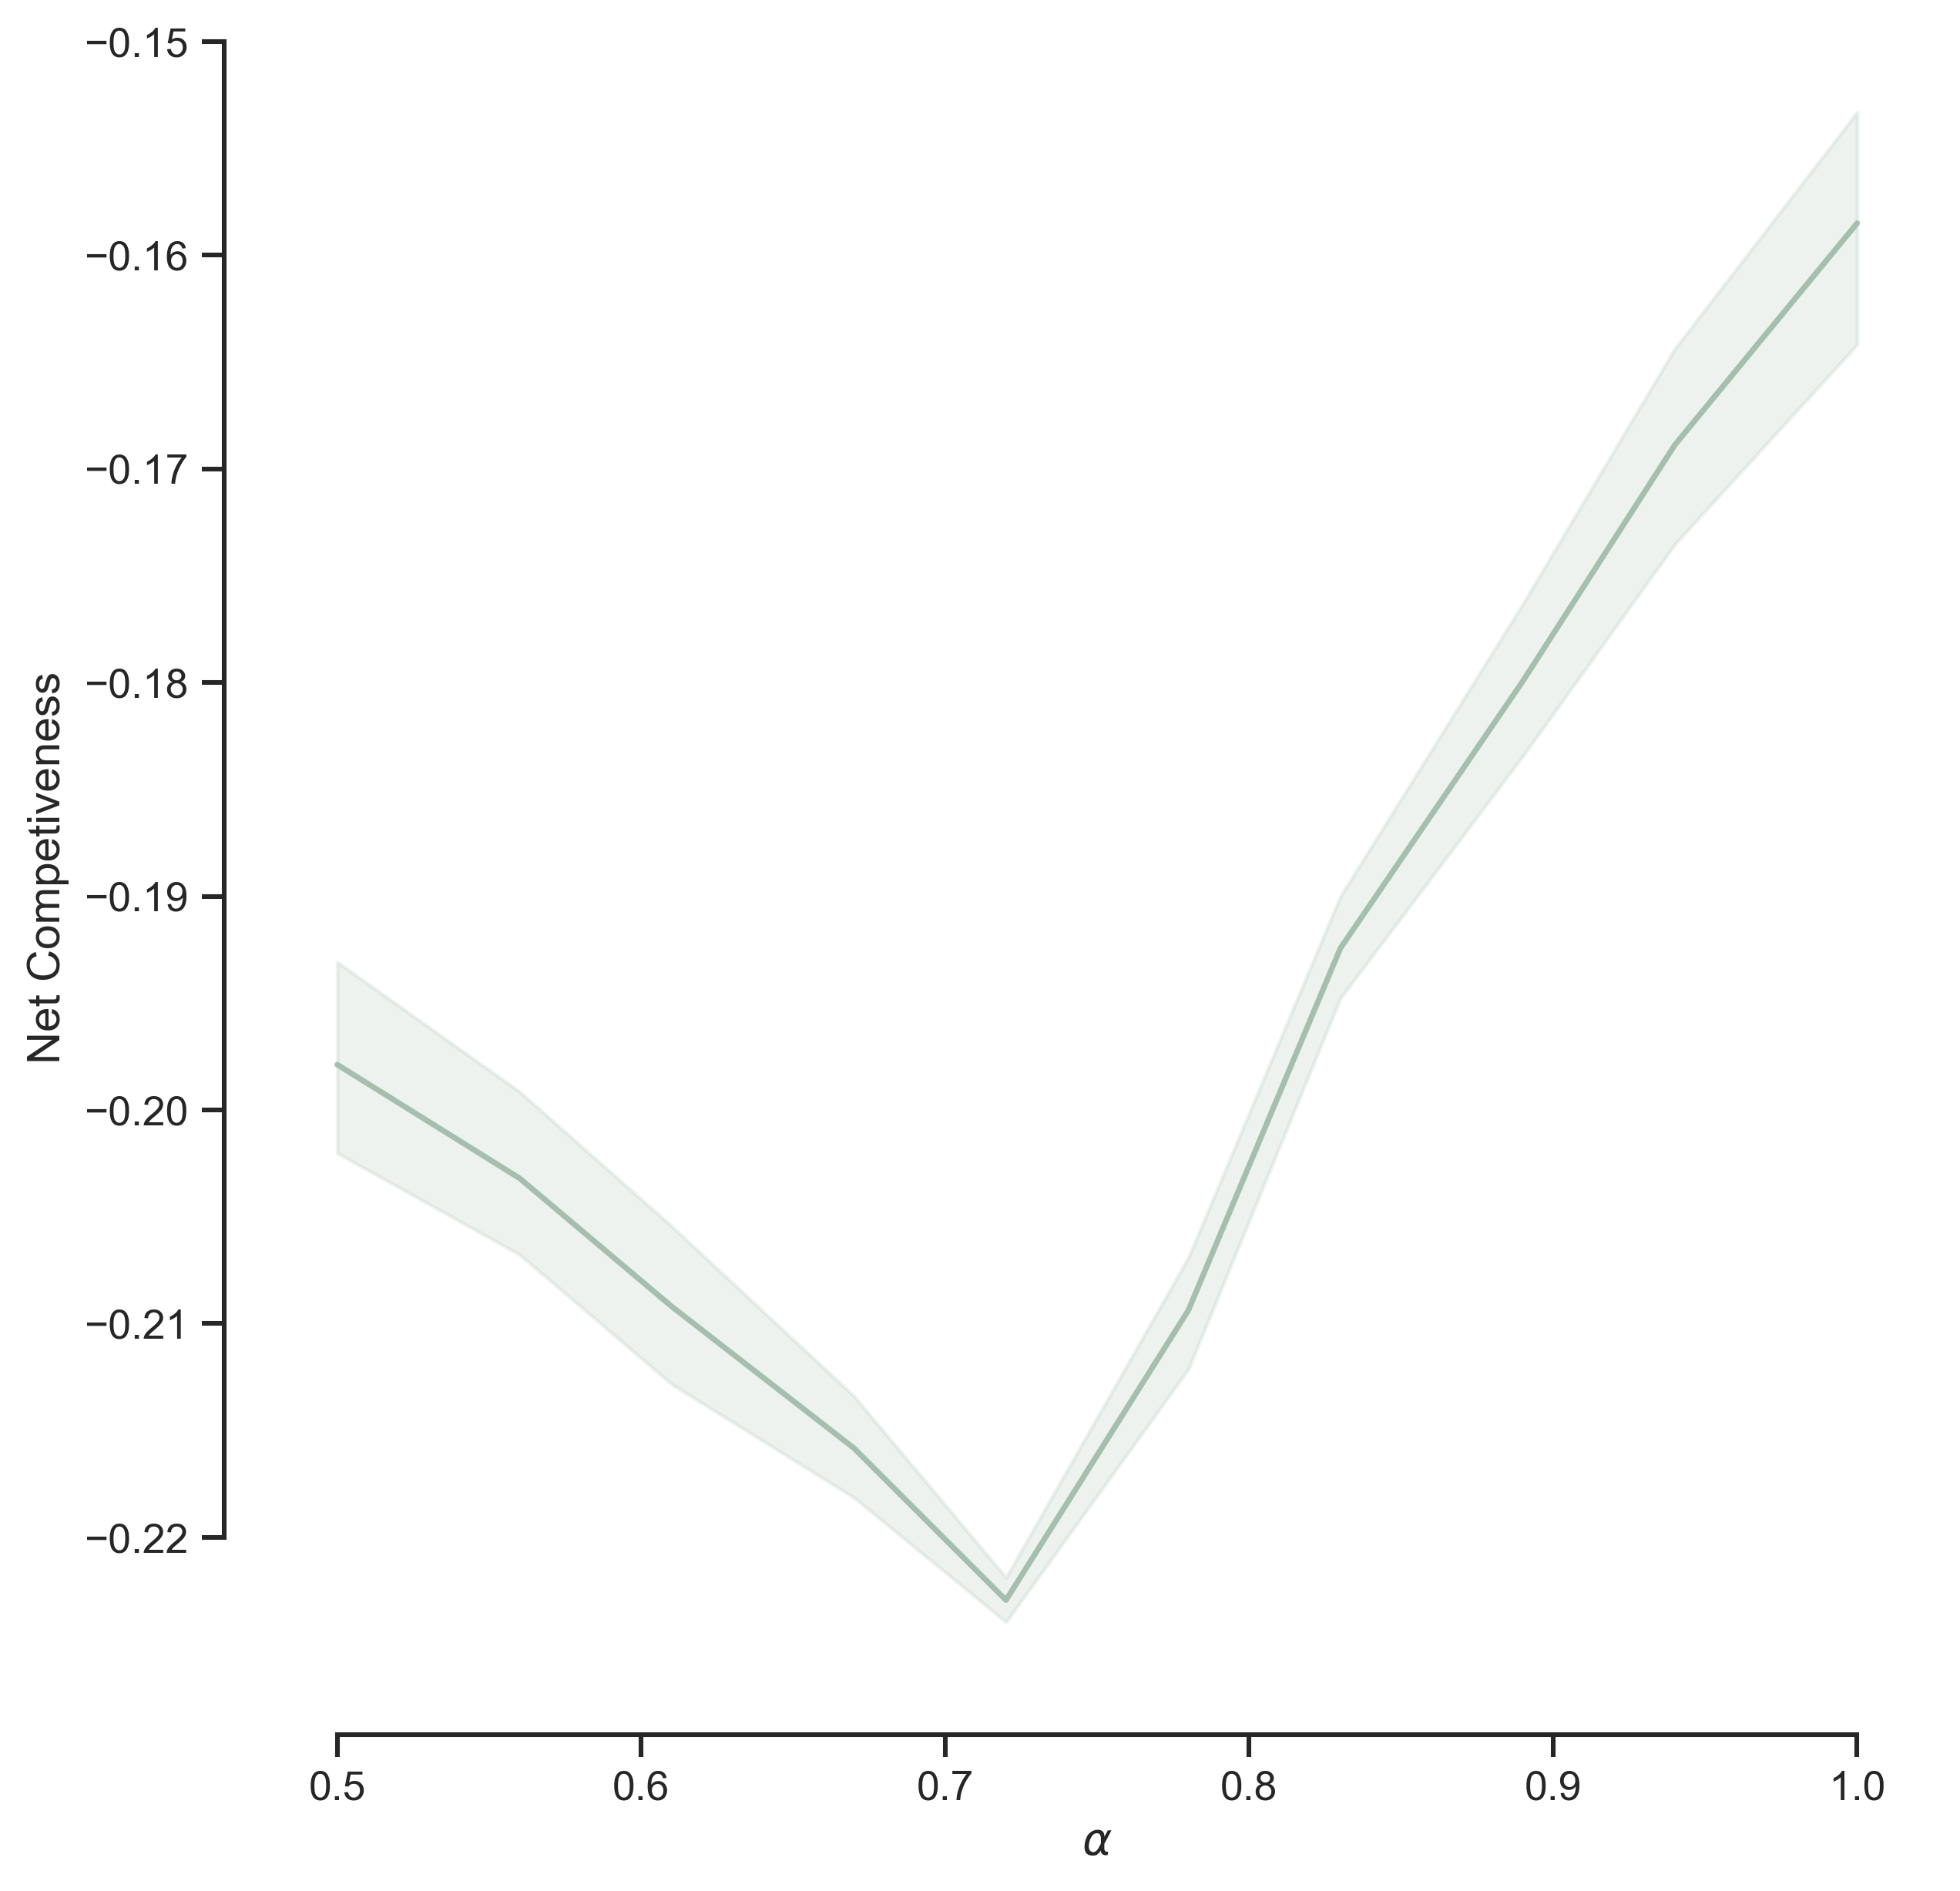

In [199]:
fig, axes = plt.subplots(1, 1, figsize=(8, 8), dpi=350)
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
sns.lineplot(data=comp_dfa, x='alpha', y='Net competition', color='#A5BFAF')

sns.despine(trim=True, offset=10)
axes.set_xlabel('$\\alpha$')
axes.set_ylabel('Net Competiveness')
fig.savefig('..\Results\Figures\\netCompetiveness_alpha.png')

In [264]:
densityl = []
adjd = []
facilitation = []
sample = [f'sample {i}' for i in range(1, 11)]
for i in range(len(exp)):
    temdl = []
    temadj = []
    temfacilitation = []
    for j in range(10):
        para = betas[str(exp[i])][j]['para']
        Ct = betas[str(exp[i])][j]['Ct']
        Rt = betas[str(exp[i])][j]['Rt']
        
        _, dG, _, _, adjvin, tnfaci  = graph_dictL(para, Ct, Rt)
        density = nx.density(dG)
        temdl.append(density)
        temadj.append(np.mean(adjvin)) # Competiveness
        # temdl.append(dG.number_of_edges()/(70*150))
        temfacilitation.append(np.mean(tnfaci)) # facilitation
    tdf = pd.DataFrame({'Sample': sample, 'Density': temdl, 'betas':[exp[i]]*10})
    adjddf = pd.DataFrame({'Sample': sample, 'Competiveness': temadj, 'Facilitation':temfacilitation, 'betas':[exp[i]]*10})
    densityl.append(tdf)
    adjd.append(adjddf)

densitydfb = pd.concat(densityl)
comp_dfb = pd.concat(adjd)
comp_dfb['Net competition'] = comp_dfb['Competiveness'] - comp_dfb['Facilitation']
densitydfb.index = np.arange(100)

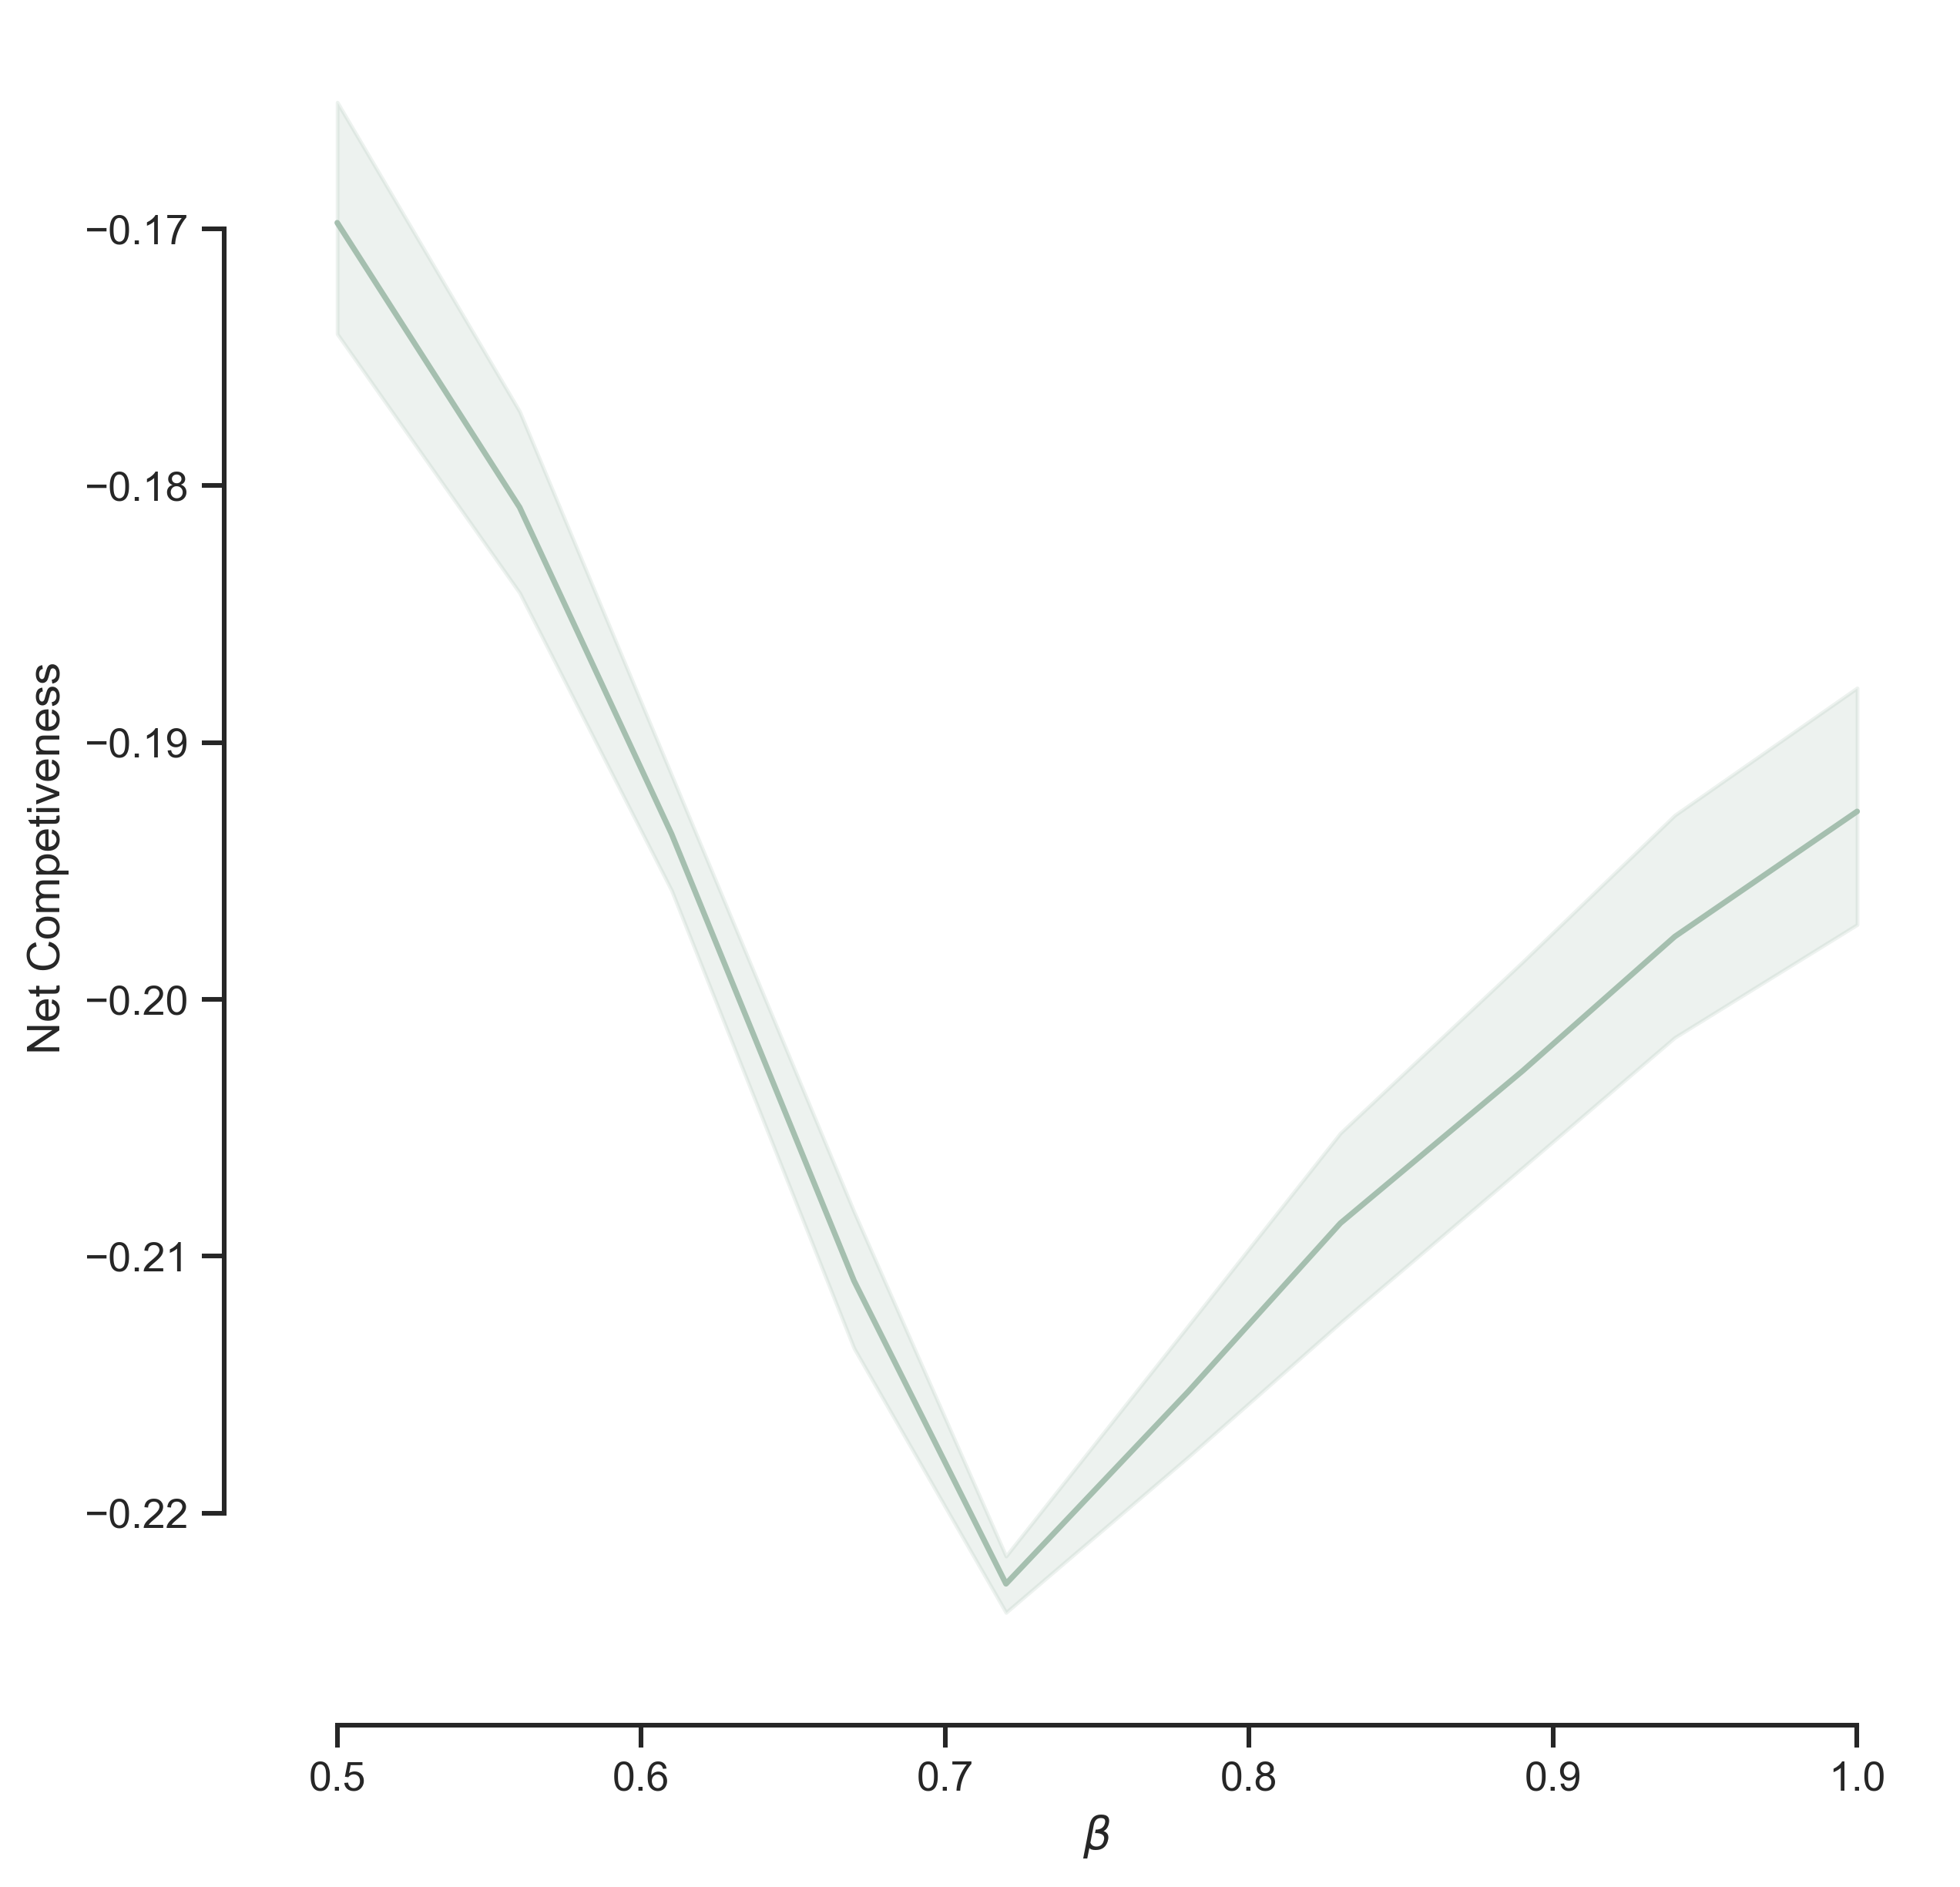

In [202]:
fig, axes = plt.subplots(1, 1, figsize=(8, 8), dpi=350)
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
sns.lineplot(data=comp_dfb, x='betas', y='Net competition', color='#A5BFAF')
sns.despine(trim=True, offset=10)
axes.set_xlabel('$\\beta$')
axes.set_ylabel('Net Competiveness')
fig.savefig('..\Results\Figures\\netCompetiveness_veta.png')

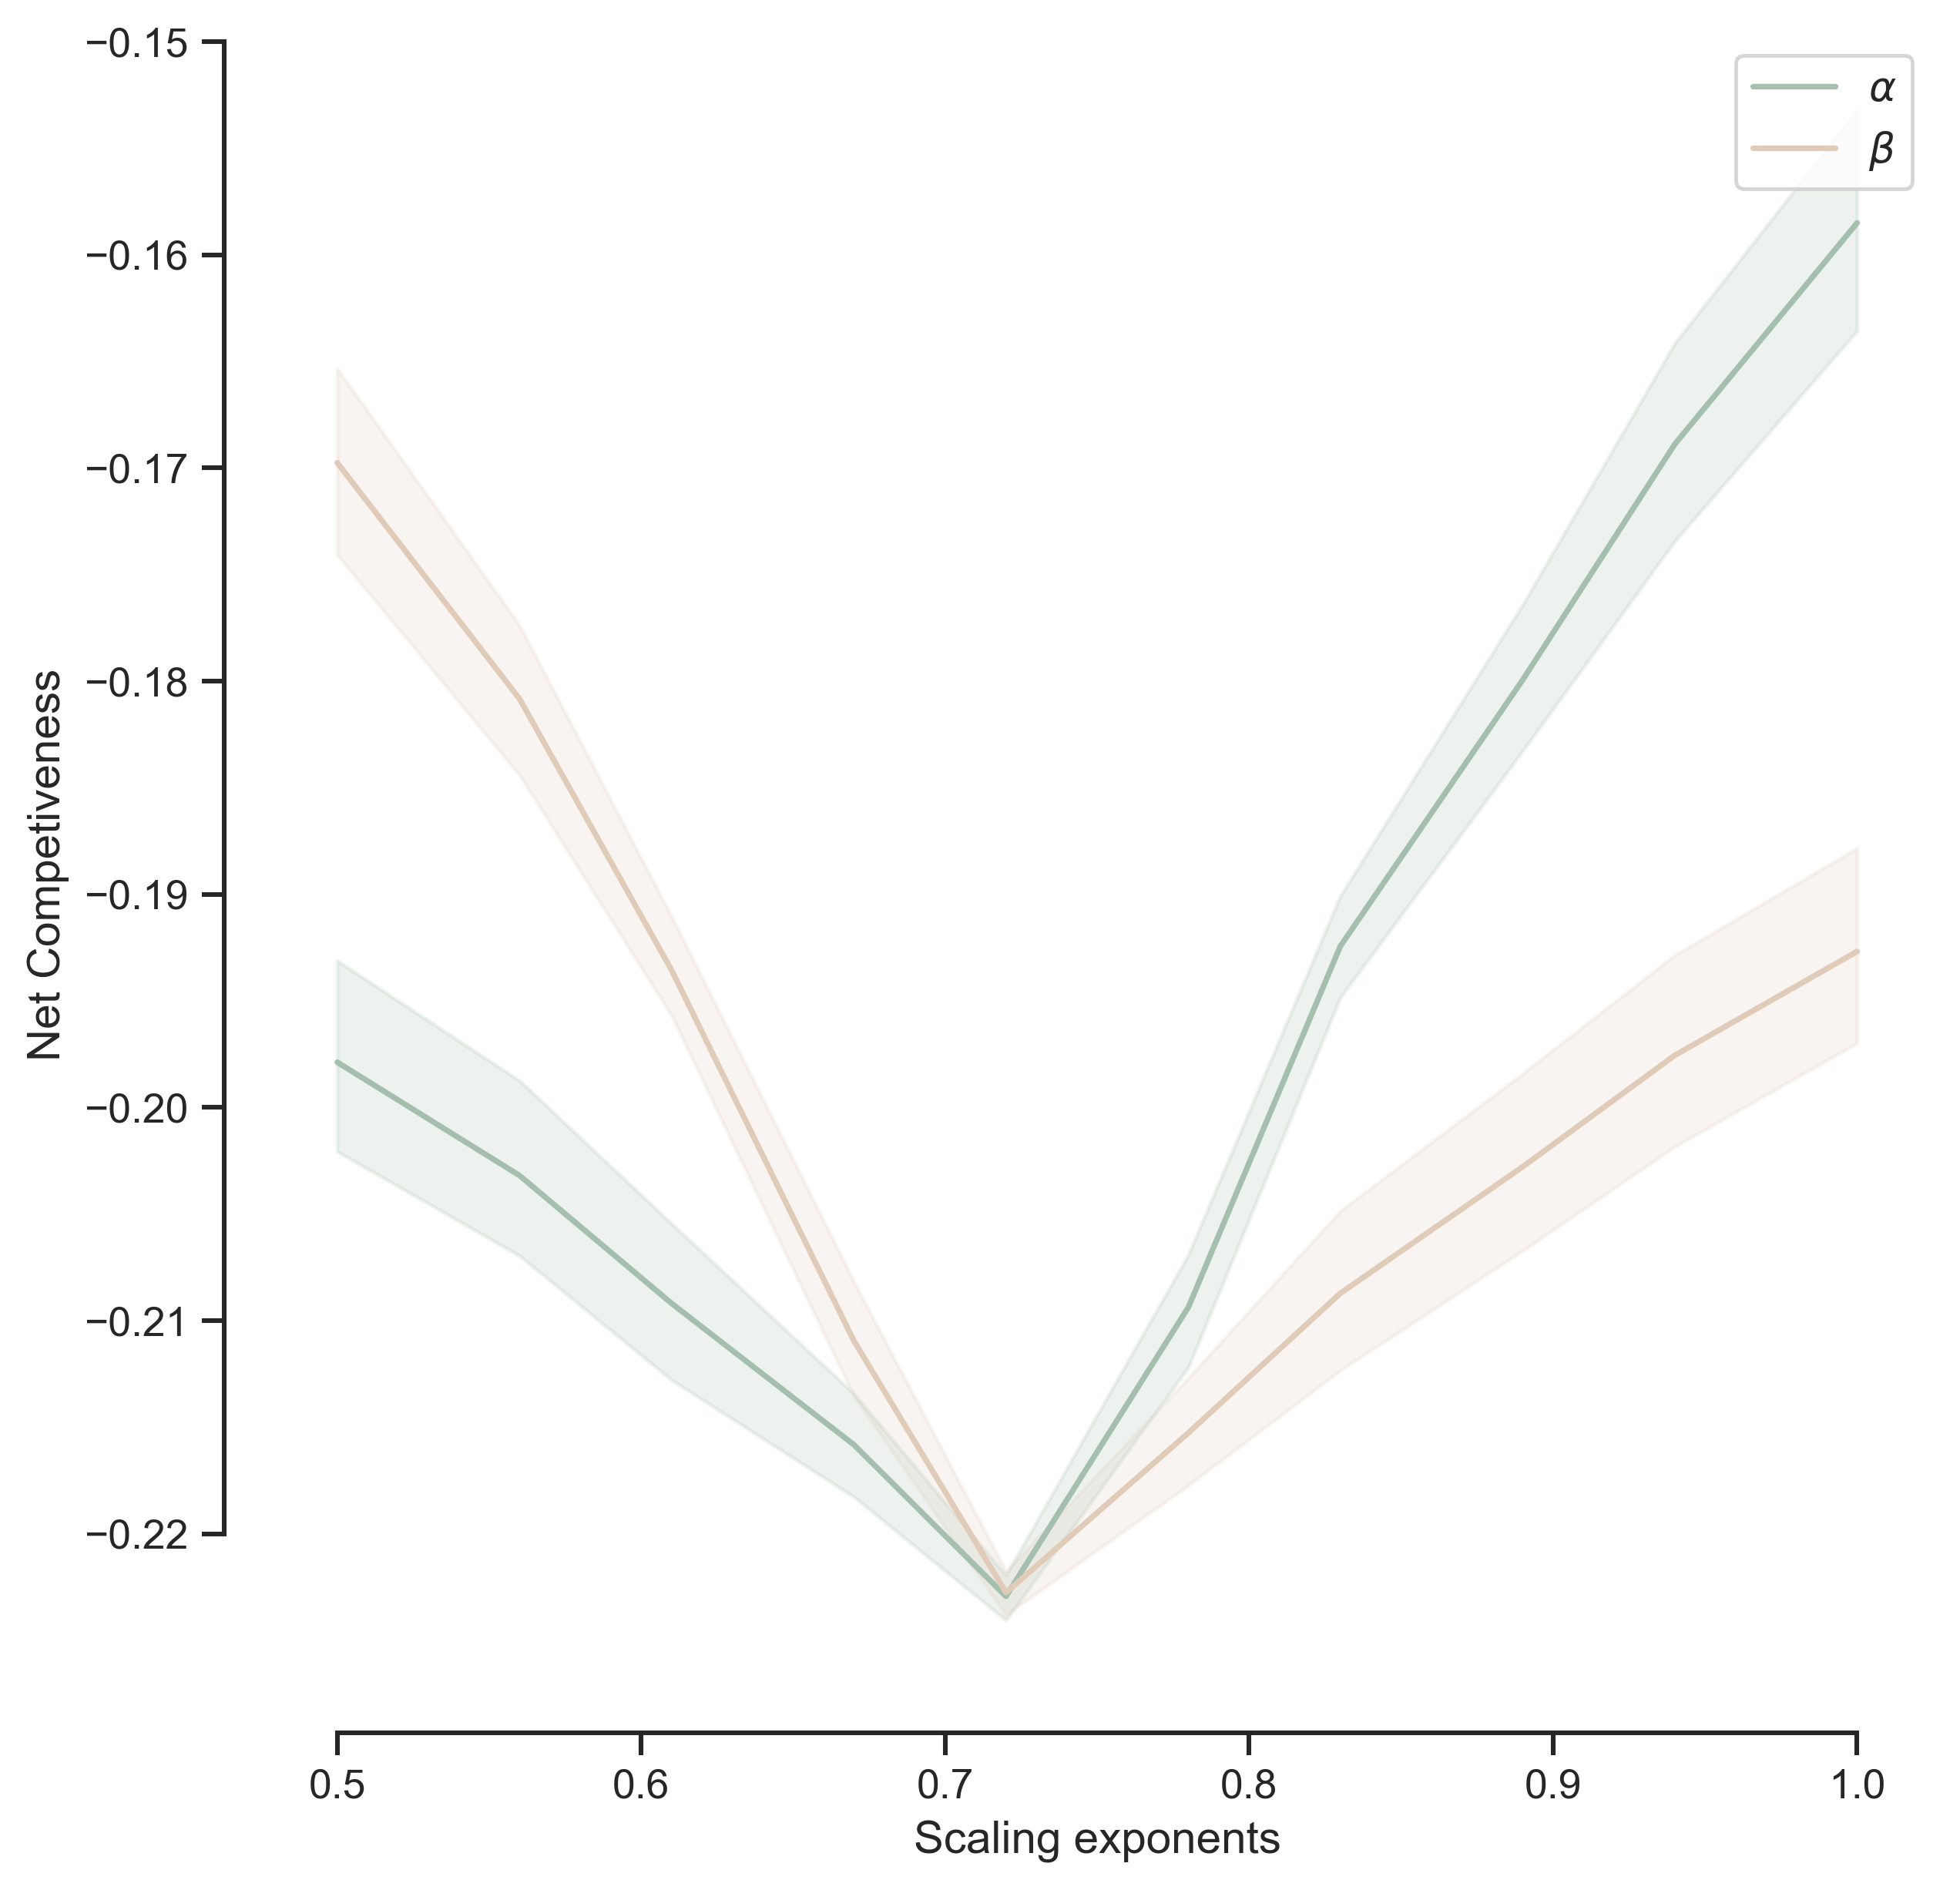

In [208]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the figure and axes
fig, axes = plt.subplots(1, 1, figsize=(8, 8), dpi=350)
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

# Plot the lines
line1 = sns.lineplot(data=comp_dfa, x='alpha', y='Net competition', color='#A5BFAF', ax=axes, label='$\\alpha$')
line2 = sns.lineplot(data=comp_dfb, x='betas', y='Net competition', color='#E0CBB9', ax=axes, label='$\\beta$')

# Remove spines
sns.despine(trim=True, offset=10)

# Set labels
axes.set_xlabel('Scaling exponents')
axes.set_ylabel('Net Competiveness')

# Add legend
axes.legend()


# Save the figure
fig.savefig('..\Results\Figures\\netCompetiveness_all.png')


# Plotting figures for graph density

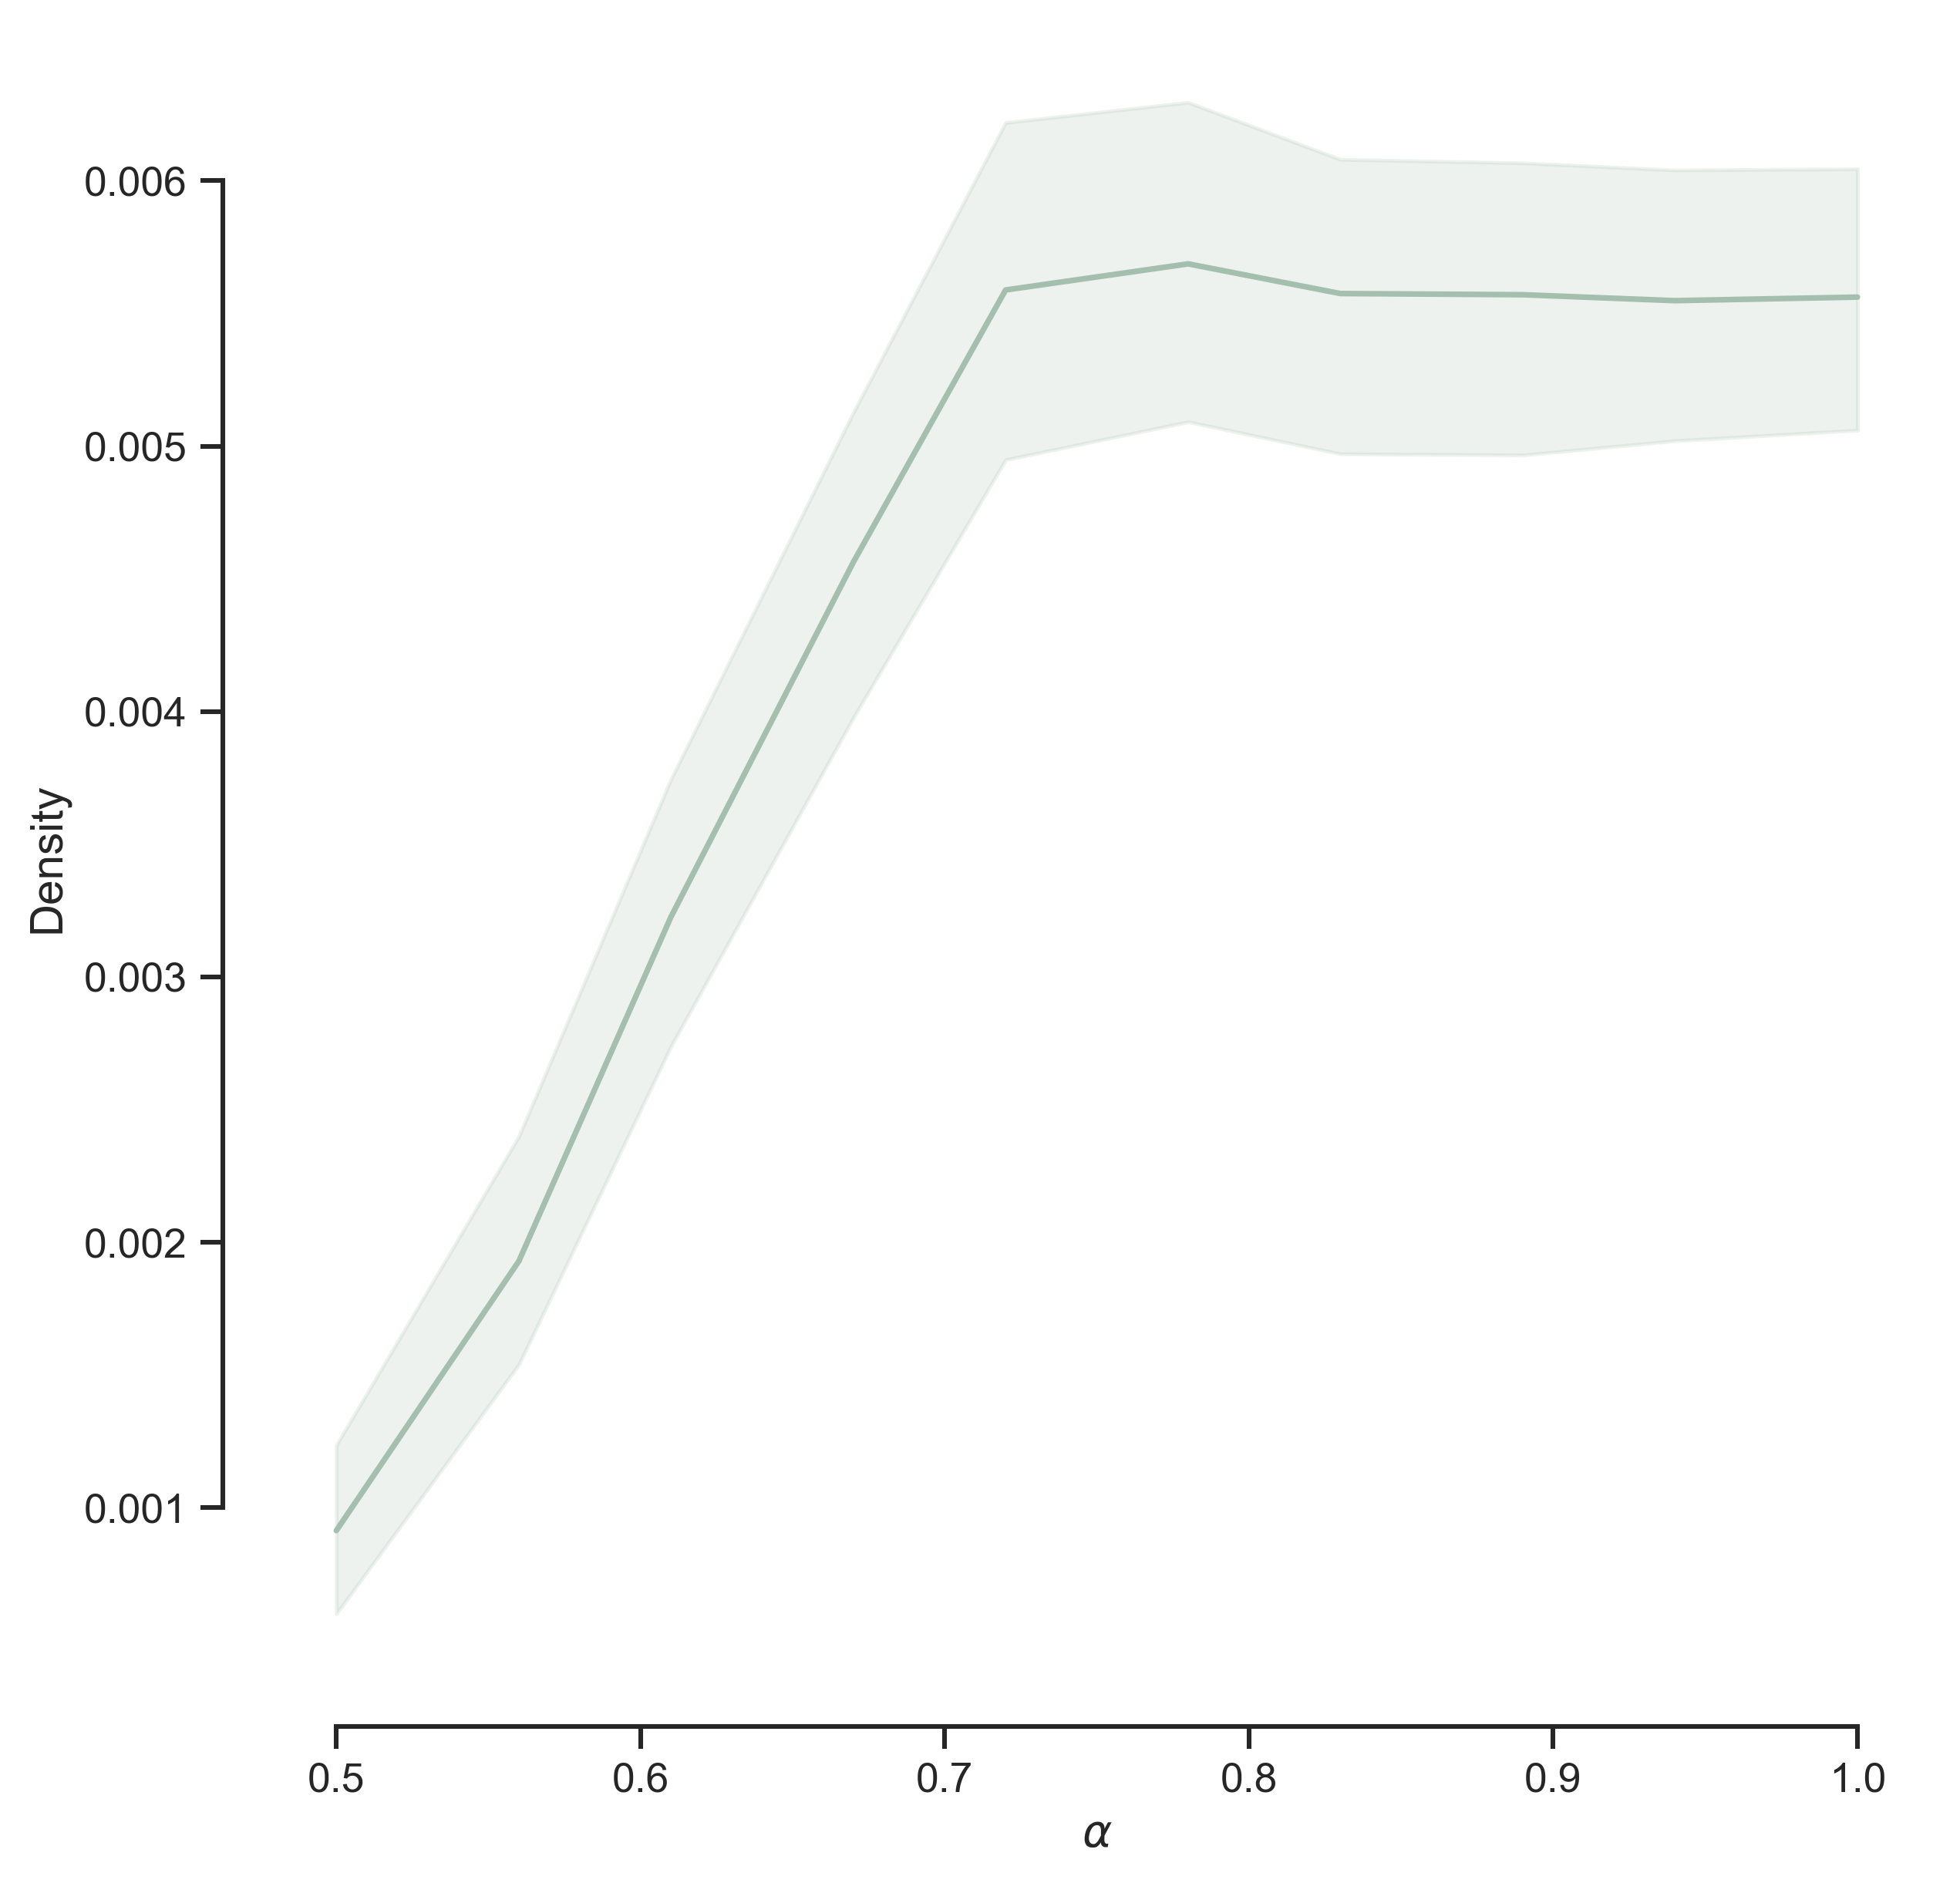

In [183]:
fig, axes = plt.subplots(1, 1, figsize=(8, 8), dpi=350)
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
sns.lineplot(data=densitydfa, x='alpha', y='Density', color='#A5BFAF')
sns.despine(trim=True, offset=10)
axes.set_xlabel('$\\alpha$')
fig.savefig('..\Results\Figures\\gDensity_alpha.png')

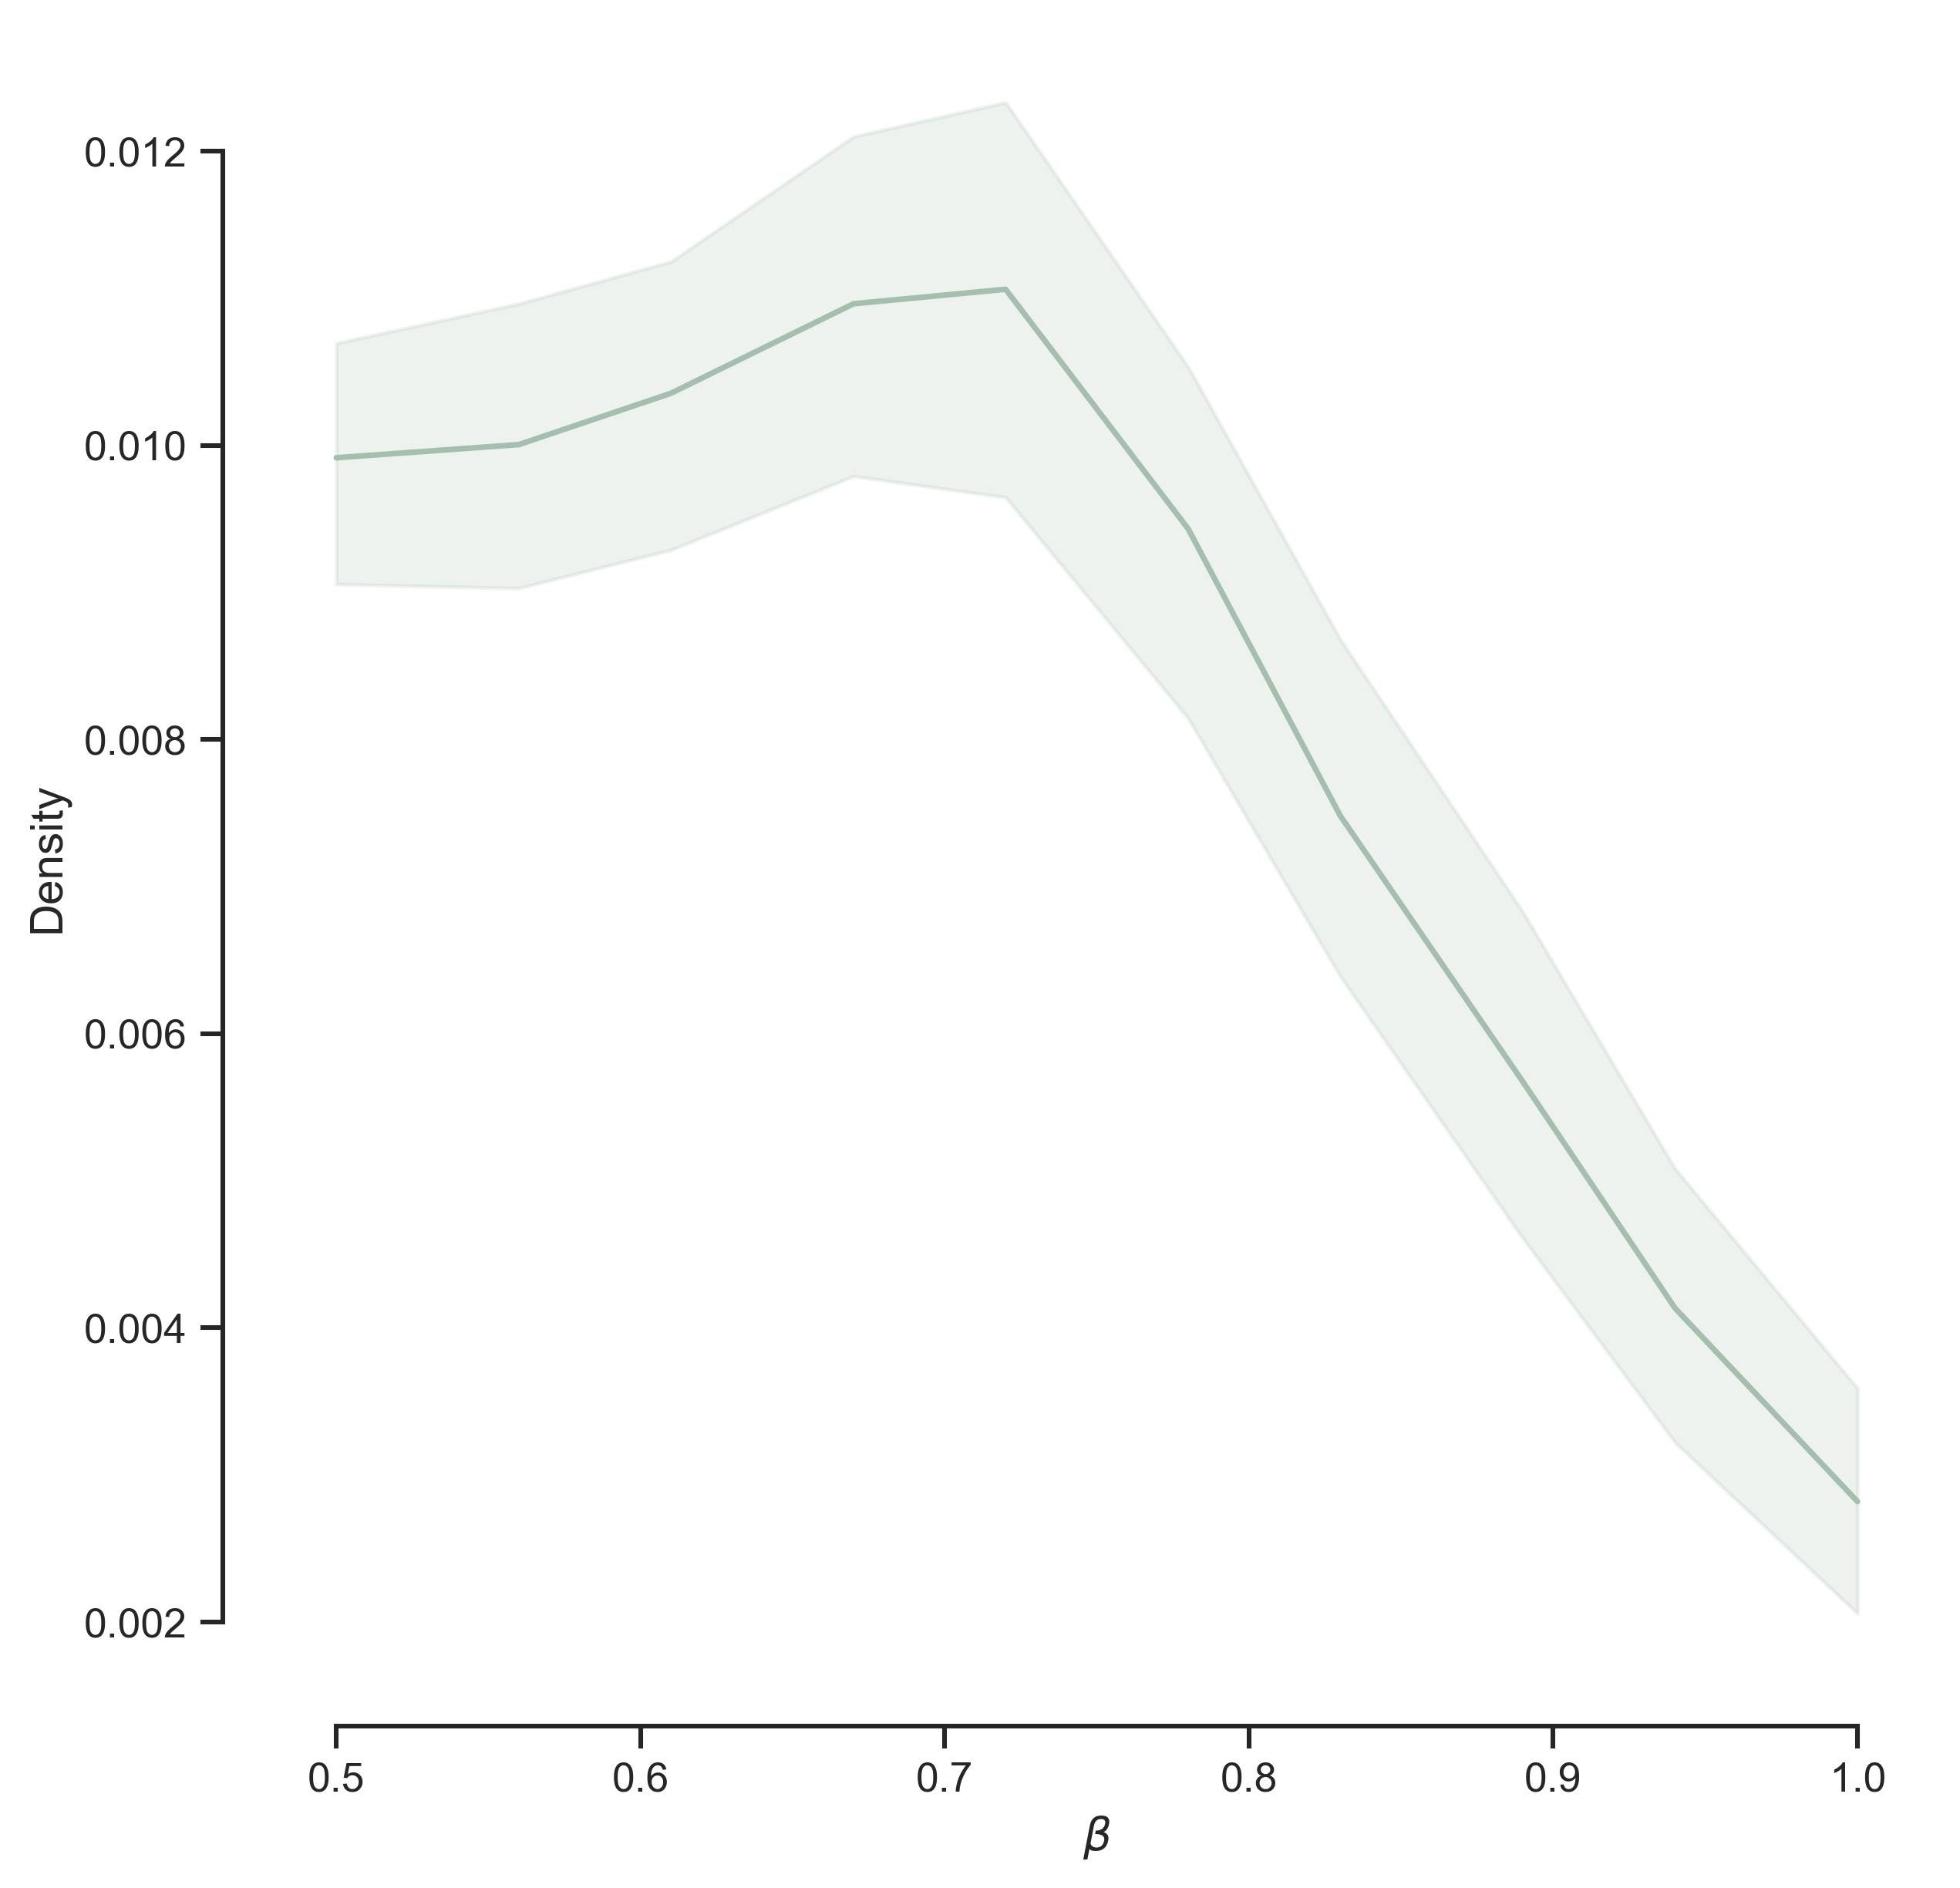

In [184]:
fig, axes = plt.subplots(1, 1, figsize=(8, 8), dpi=350)
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
sns.lineplot(data=densitydfb, x='betas', y='Density', color='#A5BFAF')
sns.despine(trim=True, offset=10)
axes.set_xlabel('$\\beta$')
fig.savefig('..\Results\Figures\\gDensity_beta.png')

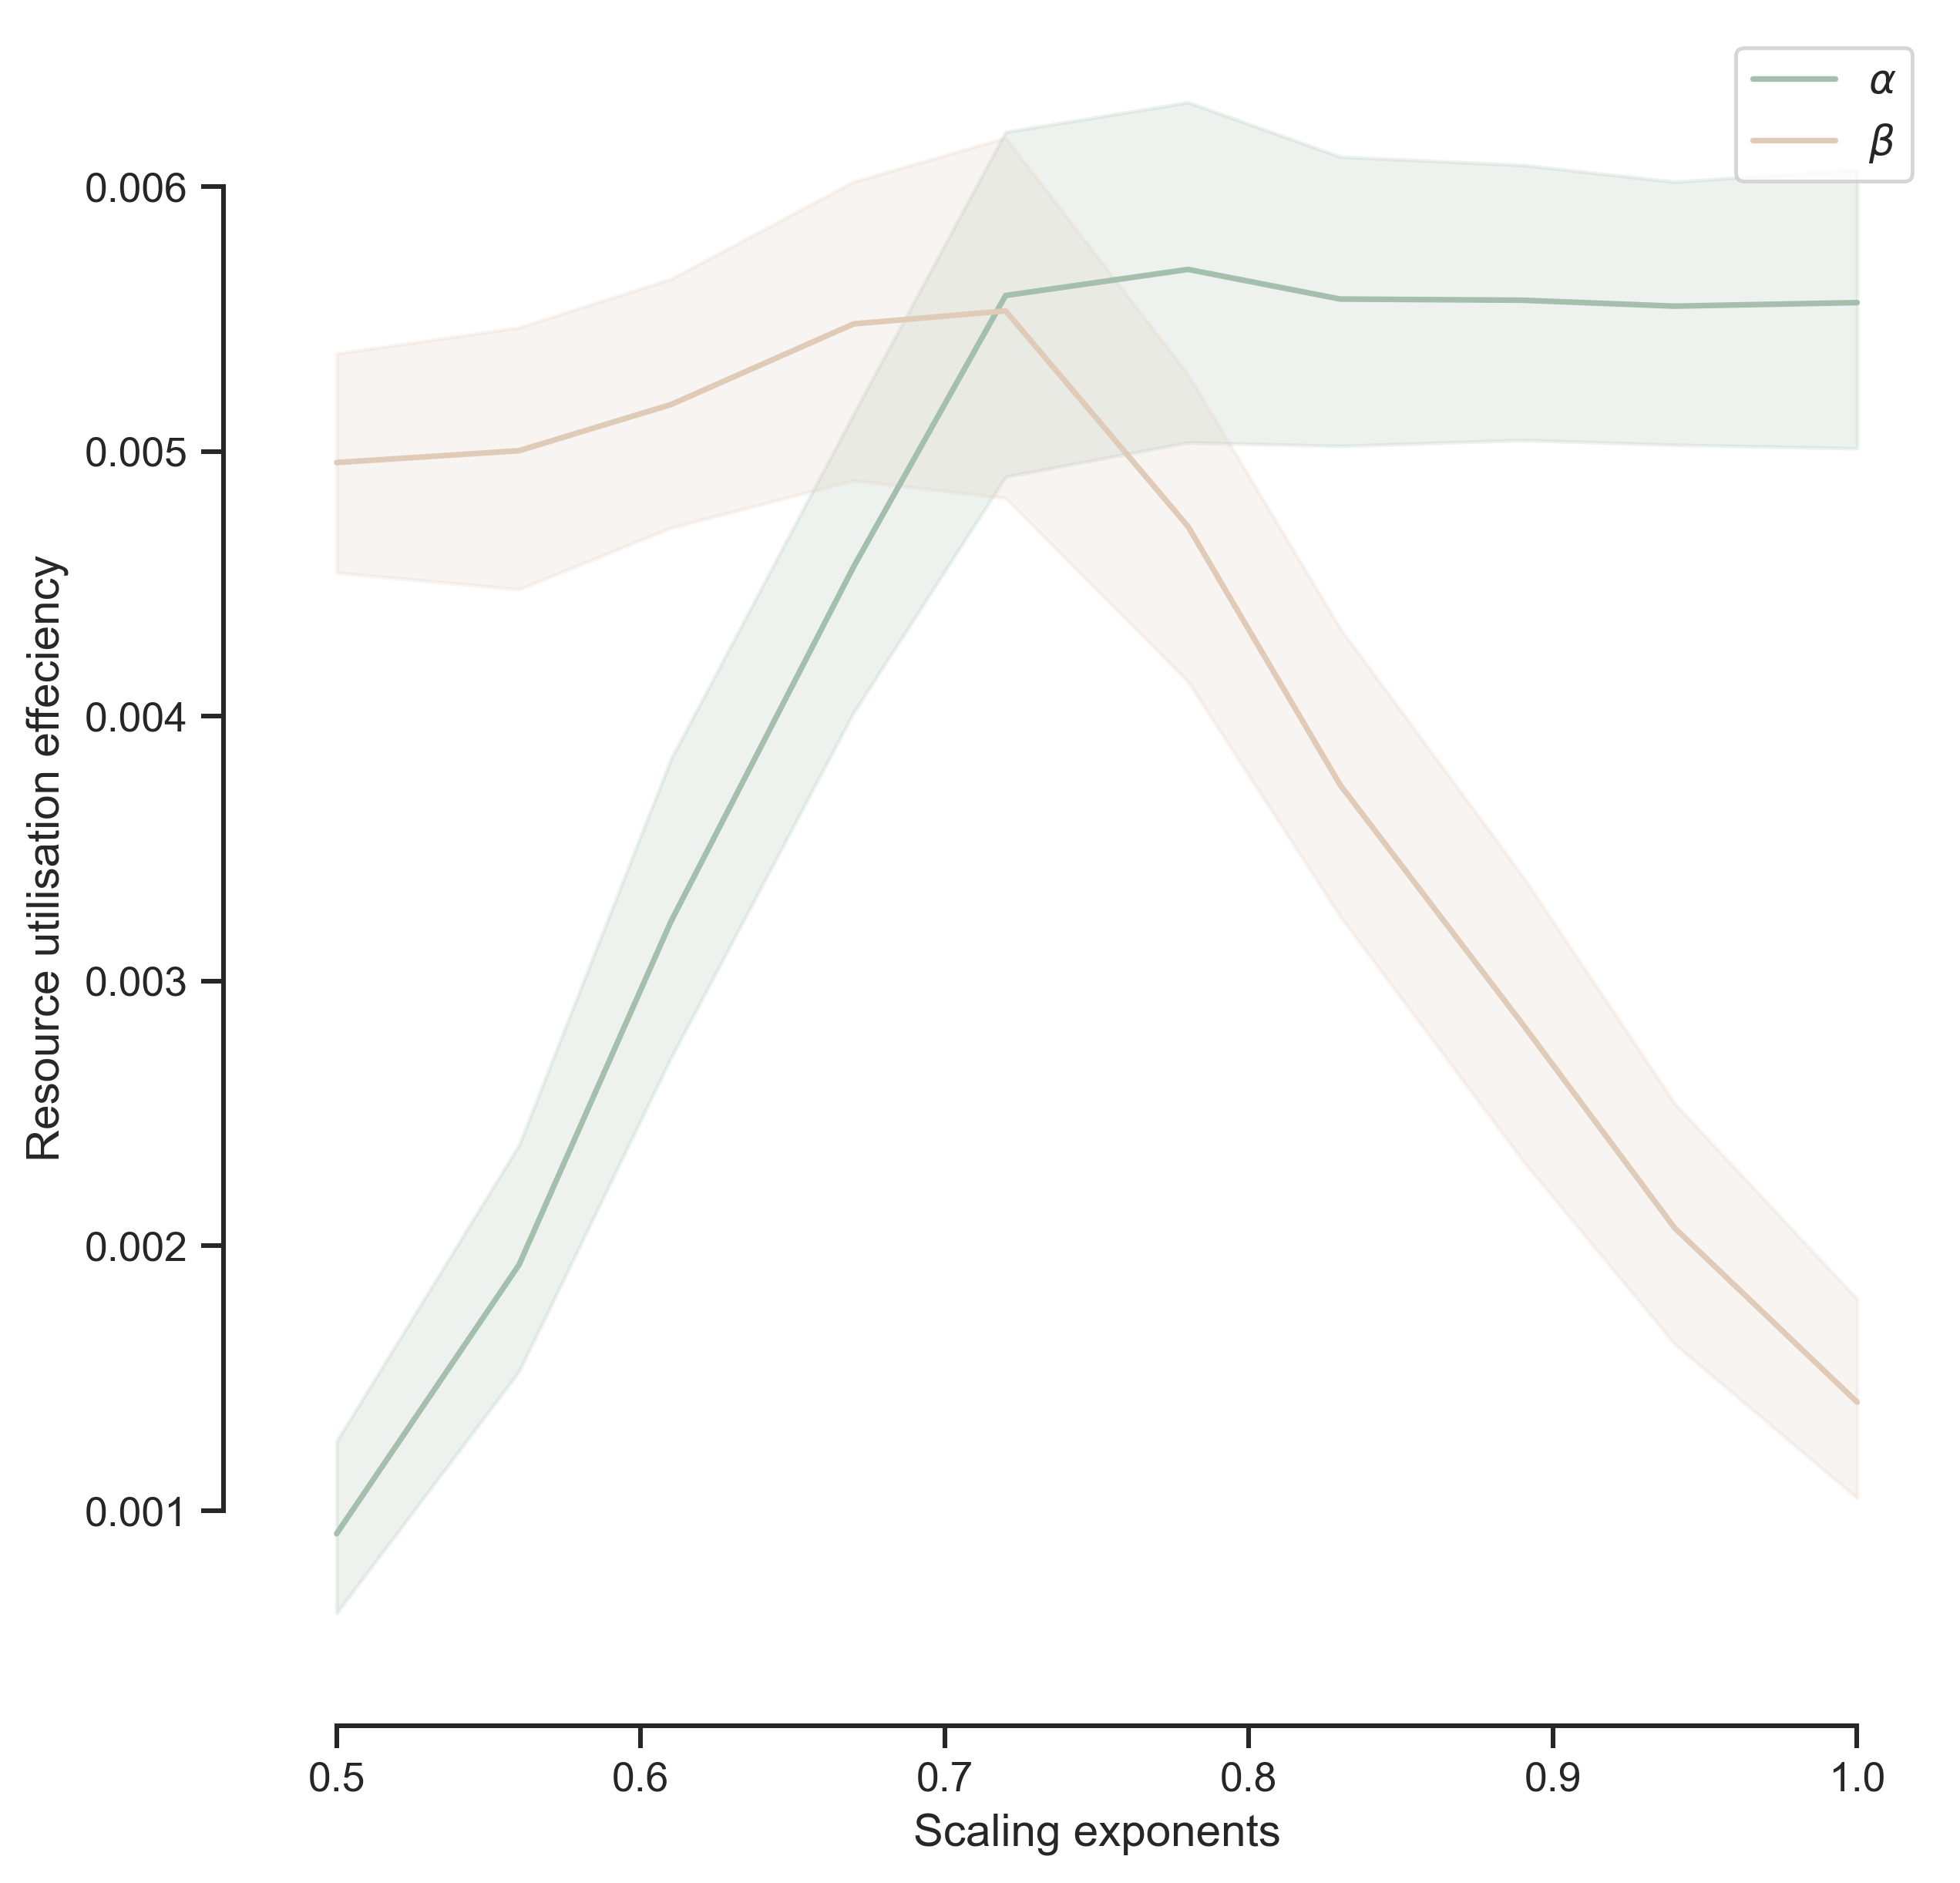

In [267]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8), dpi=350)
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
line1 = sns.lineplot(data=densitydfa, x='alpha', y='Density', color='#A5BFAF', ax=ax, label='$\\alpha$')
line2 = sns.lineplot(data=densitydfb, x='betas', y='Density', color='#E0CBB9', ax=ax, label='$\\beta$')
ax.legend()
sns.despine(trim=True, offset=10)
ax.set_ylabel('Resource utilisation effeciency')
ax.set_xlabel('Scaling exponents')
fig.savefig('..\Results\Figures\\gDensity_all.png')

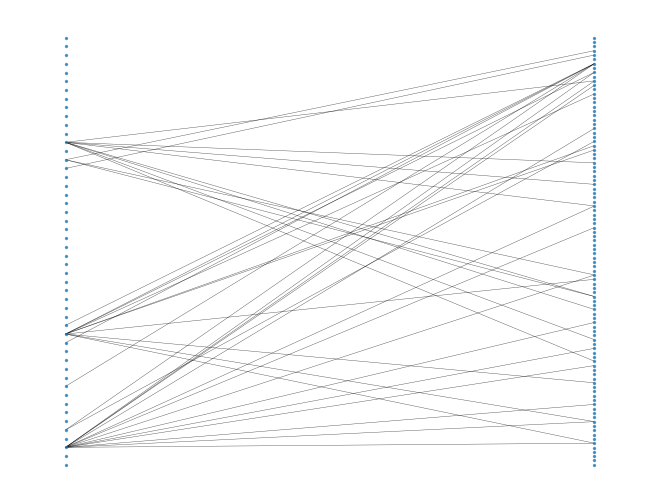

In [51]:
pos = nx.bipartite_layout(dG, nl)
custom_params = {
    'node_size': 2,
    'width': 0.3,
    'alpha': 0.7,
    'with_labels':False
}
nx.draw(dG, pos, **custom_params)
# Set the DPI value
dpi = 350  # Set the desired DPI value

# Save the figure with the specified DPI
plt.savefig('..\Results\Figures\\sampleBipartile.png', dpi=dpi)

# Test for correlation between competiveness and richenss

## Load data

In [214]:
alphas = []
betas = []
for i in range(10):
    dir = f'F:\Study\FYP\CellSizeBCAu\Data\\alphas\pair_{i+1}'
    alphas.append(load_data(dir, 10, 'all'))
    dir = f'F:\Study\FYP\CellSizeBCAu\Data\\betas\pair_{i+1}'
    betas.append(load_data(dir, 10, 'all'))

In [215]:
def species_sorting(data, para:Paras):
    
    spn, t = data.shape
    avgm = para.avgm.reshape(spn,)
    feasibility = np.empty(t)

    for i in range(t):
        data[:, i] = data[:, i]/avgm
        feasibility[i] = data[data[:, i]>0.6, i].shape[0]
    return feasibility

In [216]:
def convert_dataframe_condition(conditioned_data):

    df_list = []
    for i in range(10):
        data = conditioned_data[i]
        _, t = data['Ct'].shape
        temp_dic = {k:data[k] for k in ('t', 'scaling exponents')}
        temp_dic['t'] = temp_dic['t'][0:int(0.8*t)]
        temp_dic['scaling exponents'] = [np.round(temp_dic['scaling exponents'], 2)]*t
        temp_dic['scaling exponents'] = temp_dic['scaling exponents'][0:int(0.8*t)]
        if 'sample number' in temp_dic.keys():
            temp_dic['sample number'].append([f'sample {i+1}' for _ in range(int(0.8*t))]) 
        else:
            temp_dic['sample number'] = [f'sample {i+1}' for _ in range(int(0.8*t))]
        temp_dic['sample number'] = np.array(temp_dic['sample number']).flatten()
        feasibility = species_sorting(data['Ct'], data['para'])[0:int(0.8*t)]
        temp_dic['Coexsistence'] = feasibility
        df_list.append(pd.DataFrame.from_dict(temp_dic))

    return pd.concat(df_list)


In [217]:
dfsa = []
for j in range(len(alphas)):
    sample_df = convert_dataframe_condition(alphas[j])
    dfsa.append(sample_df)
all_pair_df_alphas = pd.concat(dfsa)
dfs = []
for j in range(len(betas)):
    sample_df = convert_dataframe_condition(betas[j])
    dfs.append(sample_df)
all_pair_df_betas = pd.concat(dfs)

In [218]:
finaldfa = all_pair_df_alphas[all_pair_df_alphas['t'] == all_pair_df_alphas['t'].iloc[-1]]
finaldfa['scaling exponents'] = [finaldfa['scaling exponents'].iloc[i][0] for i in range(100)]
finaldfb = all_pair_df_betas[all_pair_df_betas['t'] == all_pair_df_betas['t'].iloc[-1]]
finaldfb['scaling exponents'] = [finaldfb['scaling exponents'].iloc[i][1] for i in range(100)]

C:\Users\IVANN\AppData\Local\Temp\ipykernel_154796\2880788427.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  finaldfa['scaling exponents'] = [finaldfa['scaling exponents'].iloc[i][0] for i in range(100)]
C:\Users\IVANN\AppData\Local\Temp\ipykernel_154796\2880788427.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  finaldfb['scaling exponents'] = [finaldfb['scaling exponents'].iloc[i][1] for i in range(100)]


## Correlation

- datasets
    - for $\alpha$ `finaldfa` (Richness), `comp_dfa` (competiveness)
    - for $\beta$ `finaldfb` (Richness), `comp_dfb` (competiveness)

In [220]:
comp_dfa

,Sample,Competiveness,Facilitation,alpha,Net competition
0,sample 1,0.215272,0.408022,0.5,-0.192750
1,sample 2,0.213154,0.395508,0.5,-0.182354
2,sample 3,0.219708,0.415094,0.5,-0.195386
3,sample 4,0.217048,0.415465,0.5,-0.198417
4,sample 5,0.214109,0.421254,0.5,-0.207145
...,...,...,...,...,...
5,sample 6,0.215469,0.367717,1.0,-0.152248
6,sample 7,0.214271,0.382945,1.0,-0.168674
7,sample 8,0.218200,0.386993,1.0,-0.168794
8,sample 9,0.219718,0.364749,1.0,-0.145032


In [221]:
finaldfa

,t,scaling exponents,sample number,Coexsistence
7999,23999.39994,0.5,sample 1,17.0
7999,23999.39994,0.5,sample 2,15.0
7999,23999.39994,0.5,sample 3,18.0
7999,23999.39994,0.5,sample 4,20.0
7999,23999.39994,0.5,sample 5,22.0
...,...,...,...,...
7999,23999.39994,1.0,sample 6,16.0
7999,23999.39994,1.0,sample 7,13.0
7999,23999.39994,1.0,sample 8,16.0
7999,23999.39994,1.0,sample 9,16.0


In [225]:
x = comp_dfa['Net competition']
y = finaldfa['Coexsistence']
correlation, p_value = stats.pearsonr(x, y)
n = len(x)
df = n - 2
print(f"Pearson correlation coefficient for $\\alpha$: {correlation}")
print(f"P-value for $\\alpha$: {p_value}")
n = len(x)
df = n - 2
print(f"Degree of freedom for $\\alpha$: {df}")

Pearson correlation coefficient for $\alpha$: -0.7950913522675751
P-value for $\alpha$: 5.2360690775768233e-23
Degree of freedom for $\alpha$: 98


In [226]:
x = comp_dfb['Net competition']
y = finaldfb['Coexsistence']
correlation, p_value = stats.pearsonr(x, y)
n = len(x)
df = n - 2
print(f"Pearson correlation coefficient for $\\beta$: {correlation}")
print(f"P-value for $\\beta$: {p_value}")
print(f"Degree of freedom for $\\beta$: {df}")

Pearson correlation coefficient for $\beta$: -0.8420241911781523
P-value for $\beta$: 5.111396507846439e-28
Degree of freedom for $\beta$: 98


In [268]:
x = densitydfa['Density']
y = finaldfa['Coexsistence']
correlation, p_value = stats.pearsonr(x, y)
print(f"Pearson correlation coefficient for $\\alpha$: {correlation}")
print(f"P-value for $\\alpha$: {p_value}")
n = len(x)
df = n - 2
print(f"Degree of freedom for $\\alpha$: {df}")

Pearson correlation coefficient for $\alpha$: 0.02192123752896592
P-value for $\alpha$: 0.828611794745325
Degree of freedom for $\alpha$: 98


In [269]:
x = densitydfb['Density']
y = finaldfb['Coexsistence']
correlation, p_value = stats.pearsonr(x, y)
print(f"Pearson correlation coefficient for $\\beta$: {correlation}")
print(f"P-value for $\\beta$: {p_value}")
n = len(x)
df = n - 2
print(f"Degree of freedom for $\\beta$: {df}")

Pearson correlation coefficient for $\beta$: 0.1289799008067451
P-value for $\beta$: 0.2009208355352785
Degree of freedom for $\beta$: 98
